<a href="https://colab.research.google.com/github/Mrcyoga10004/Deep-Learning/blob/main/Tugas_Week_3_CNN_Models_CIFAR_100_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Marcelleno Yoga
Nim : 1103210004
Tugas 3 CNN- Models: CIFAR-100 Datasets

# Persiapan: Instalasi library

In [ ]:
%pip install numpy matplotlib scikit-learn torch tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

# Deep Learning Menggunakan PyTorch (MLP dan CNN)

### 1. Mengimpor Library yang Dibutuhkan

In [ ]:
# Import library yang diperlukan
import torch # Library utama untuk deep learning
import torch.nn as nn # Library untuk neural network
import torch.optim as optim # Library untuk optimizers
import torch.nn.functional as F # Library untuk fungsi aktivasi dan loss functions
import torchvision # Library untuk computer vision
import torchvision.transforms as transforms # Library untuk transformasi data
import numpy as np # Library untuk manipulasi array
import matplotlib.pyplot as plt # Library untuk visualisasi data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix

# Mengatur device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Menggunakan GPU jika tersedia, jika tidak menggunakan CPU
print(f"Menggunakan device: {device}")

Menggunakan device: cpu


### 2. Mendefinisikan Transformasi Data dan Memuat Dataset CIFAR-10

In [ ]:
# Data transformations
# Transformasi data untuk augmentasi dan normalisasi
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    ])

# Memuat dataset CIFAR-10
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=2)

# Kelas untuk CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:03<00:00, 55.4MB/s]


### 3. Menyiapkan Fungsi Pelatihan dan Validasi

In [ ]:
# Fungsi untuk melatih model
def train_model(model, trainloader, criterion, optimizer, scheduler, epochs=100):
    train_losses = [] # List untuk menyimpan loss
    train_accuracies = [] # List untuk menyimpan akurasi

    # Perulangan untuk setiap epoch
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        model.train() # Mengatur model ke mode training
        # Perulangan untuk setiap batch dalam trainloader
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data # Mengambil data dan label dari batch
            # Memindahkan data dan label ke device (GPU/CPU)
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad() # Mengatur gradien ke nol sebelum backward pass

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Menghitung akurasi
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Menghitung rata-rata loss dan akurasi untuk epoch ini
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * correct / total

        # Validasi dan penyesuaian learning rate
        val_loss, val_acc = evaluate_model(model, testloader, criterion)
        scheduler.step(val_loss) # Menyesuaikan learning rate berdasarkan validasi loss

        # Menyimpan loss dan akurasi untuk epoch ini
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%')

    return train_losses, train_accuracies

# Fungsi untuk evaluasi model
def evaluate_model(model, dataloader, criterion):
    model.eval() # Mengatur model ke mode evaluasi
    val_loss = 0.0
    correct = 0
    total = 0

    # Perulangan untuk setiap batch dalam dataloader
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return val_loss / len(dataloader), 100 * correct / total

# Fungsi untuk mendapatkan prediksi lengkap
def get_all_predictions(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []
    all_probabilities = []

    # Perulangan untuk setiap batch dalam dataloader
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)

            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    return np.array(all_labels), np.array(all_predictions), np.array(all_probabilities)

### 4. Menyiapkan Fungsi Evaluasi

In [ ]:
# Metrik evaluasi yang digunakan antara lain akurasi, presisi, recall, f1-score, dan ROC AUC
# Fungsi untuk menghitung metrik evaluasi
def evaluate_metrics(y_true, y_pred, y_prob):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    roc_auc = roc_auc_score(y_true, y_prob, average='macro', multi_class='ovr')

    return accuracy, precision, recall, f1, roc_auc

### 5. Menyiapkan Fungsi Visualisasi

In [ ]:
# Fungsi untuk menampilkan plot loss dan akurasi
def visualize_results(train_losses, train_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.title('Train Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', color='orange')
    plt.title('Train Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Fungsi untuk menampilkan ROC curve
def visualize_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

# Fungsi untuk menampilkan confusion matrix
def visualize_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.matshow(cm, cmap='Blues')
    plt.colorbar()
    plt.title('Confusion Matrix')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f'{cm[i, j] / cm.sum() * 100:.1f}%', ha='center', va='bottom', color='lavender' if cm[i, j] > cm.max() / 2 else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


## A. MLP CIFAR-10 dengan PyTorch

### 1. Menyusun Model MLP Sederhana


In [ ]:
# Mendefinisikan model MLP
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Input size: 32x32x3 = 3072
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 32 * 3, 2048)
        self.bn1 = nn.BatchNorm1d(2048)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(2048, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(1024, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(512, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.dropout4 = nn.Dropout(0.25)

        self.fc5 = nn.Linear(256, len(classes)) # Output size: 10 (jumlah kelas CIFAR-10)

    # Fungsi forward untuk melakukan forward pass
    def forward(self, x):
        x = self.flatten(x)

        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)

        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout4(x)

        x = self.fc5(x)

        return x

# Inisialisasi model
model_mlp = MLP().to(device)
print(model_mlp)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=2048, bias=True)
  (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.25, inplace=False)
  (fc5): Linear(in_features=256, out_features=10, bias=True)
)


### 2. Menyiapkan Optimizer dan Loss Function

In [ ]:
# Inisialisasi loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### 3. Melatih Model

In [ ]:
# Melatih model MLP dengan data augmentation
print("Melatih model MLP...")
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model_mlp, trainloader, criterion, optimizer, scheduler, epochs=150)

# Mengevaluasi model
print("Evaluasi akhir model...")
test_loss, test_accuracy = evaluate_model(model_mlp, testloader, criterion)
print(f"Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Melatih model MLP...
Epoch 1, Loss: 1.9261, Accuracy: 29.29%, Val Loss: 1.7203, Val Accuracy: 37.55%
Epoch 2, Loss: 1.7593, Accuracy: 36.26%, Val Loss: 1.7109, Val Accuracy: 39.61%
Epoch 3, Loss: 1.6991, Accuracy: 38.52%, Val Loss: 1.6152, Val Accuracy: 42.33%
Epoch 4, Loss: 1.6573, Accuracy: 39.94%, Val Loss: 1.5777, Val Accuracy: 43.55%
Epoch 5, Loss: 1.6286, Accuracy: 41.33%, Val Loss: 1.4683, Val Accuracy: 47.54%
Epoch 6, Loss: 1.5992, Accuracy: 42.18%, Val Loss: 1.4457, Val Accuracy: 47.98%
Epoch 7, Loss: 1.5814, Accuracy: 42.74%, Val Loss: 1.4494, Val Accuracy: 48.62%
Epoch 8, Loss: 1.5679, Accuracy: 43.51%, Val Loss: 1.4466, Val Accuracy: 47.85%
Epoch 9, Loss: 1.5513, Accuracy: 44.28%, Val Loss: 1.4092, Val Accuracy: 49.73%
Epoch 10, Loss: 1.5348, Accuracy: 44.88%, Val Loss: 1.4690, Val Accuracy: 47.17%
Epoch 11, Loss: 1.5261, Accuracy: 45.26%, Val Loss: 1.3667, Val Accuracy: 50.86%
Epoch 12, Loss: 1.5162, Accuracy: 45.42%, Val Loss: 1.3795, Val Accuracy: 50.25%
Epoch 13, Loss: 

### 4. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [ ]:
# Mendapatkan semua prediksi untuk evaluasi metrik
y_true, y_pred, y_pred_proba = get_all_predictions(model_mlp, testloader)

# Menghitung metrik evaluasi
accuracy, precision, recall, f1, roc_auc = evaluate_metrics(y_true, y_pred, y_pred_proba)

# Output metrik evaluasi
print("\nMetrik Evaluasi MLP Model dengan PyTorch:")
print(f"Accuracy: {test_accuracy/100:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")



### 5. Memvisualisasikan Prediksi dari model yang telah dilatih

In [ ]:
# Plot training history
visualize_results(train_losses, train_accuracies)

# Plot ROC curve (one vs rest untuk multi-kelas)
visualize_roc_curve(y_true, y_pred_proba)

# Plot confusion matrix
visualize_confusion_matrix(y_true, y_pred)

### 6. Menyimpan Model

In [ ]:
# Menyimpan model
torch.save(model_mlp.state_dict(), 'model_pytorch_cifar-10_mlp.pth')
print("Model disimpan sebagai 'model_pytorch_cifar-10_mlp.pth'")

## B. CNN CIFAR-10 dengan PyTorch

### 1. Menyusun Model CNN Sederhana


In [ ]:
# Mendefinisikan model CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Blok konvolusi 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        # Blok konvolusi 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        # Blok konvolusi 3
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.25)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.bn7 = nn.BatchNorm1d(512)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, len(classes))

    def forward(self, x):
        # Blok 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Blok 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Blok 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Flatten
        x = x.view(-1, 128 * 4 * 4)

        # Fully connected
        x = F.relu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        x = self.fc2(x)

        return x

model_cnn = CNN().to(device)
print(model_cnn)

### 2. Menyiapkan Optimizer dan Loss Function

In [ ]:
# Inisialisasi loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, verbose=True)

### 3. Melatih Model

In [ ]:
# Melatih model
print("Melatih model CNN...")
train_losses, train_accuracies = train_model(model_cnn, trainloader, criterion, optimizer, scheduler, epochs=100)

# Mengevaluasi model
print("Evaluasi akhir model...")
test_loss, test_accuracy = evaluate_model(model_cnn, testloader, criterion)
print(f"Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Epoch 1, Loss: 1.9263, Accuracy: 29.05%, Val Loss: 1.6827, Val Accuracy: 39.27%


KeyboardInterrupt: 

### 4. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [ ]:
# Mendapatkan semua prediksi untuk evaluasi metrik
y_true, y_pred, y_pred_proba = get_all_predictions(model_cnn, testloader)

# Menghitung metrik evaluasi
accuracy, precision, recall, f1, roc_auc = evaluate_metrics(y_true, y_pred, y_pred_proba)

# Output metrik evaluasi
print("\nMetrik Evaluasi CNN Model dengan PyTorch:")
print(f"Accuracy: {test_accuracy/100:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")



Accuracy: 0.7441288090668916
Precision: 0.7237694345814063
Recall: 0.7441288090668916
F1-score: 0.7295863981229429


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 5. Memvisualisasikan Prediksi dari model yang telah dilatih

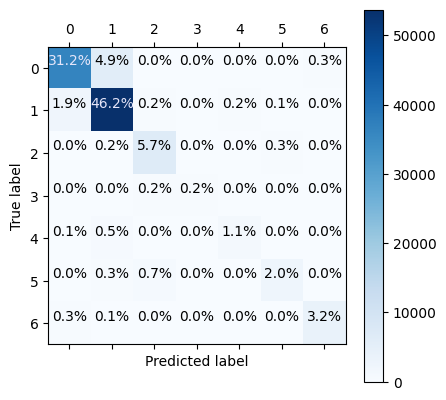

TypeError: argument of type 'History' is not iterable

In [ ]:
# Plot training history
visualize_results(train_losses, train_accuracies)

# Plot ROC curve (one vs rest untuk multi-kelas)
visualize_roc_curve(y_true, y_pred_proba)

# Plot confusion matrix
visualize_confusion_matrix(y_true, y_pred)

### 6. Menyimpan Model

In [ ]:
# Menyimpan model
torch.save(model_cnn.state_dict(), 'model_pytorch_cifar-10_cnn.pth')
print("Model disimpan sebagai 'model_pytorch_cifar-10_cnn.pth'")

# Deep Learning dengan TensorFlow (MLP dan CNN)

### 1. Import Library yang Dibutuhkan

In [ ]:
import tensorflow as tf # Library utama untuk deep learning
import tensorflow_datasets as tfds # Library untuk dataset
import numpy as np # Library untuk manipulasi array
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix # Library untuk metrik evaluasi
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization # Library untuk layer-layer CNN
from tensorflow.keras.models import Sequential # Library untuk model sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # Library untuk callbacks
from tensorflow.keras.optimizers import Adam # Library untuk optimizers

### 2. Mendefinisikan Transformasi Data dan Memuat Dataset CIFAR-10

In [ ]:
# Memuat dataset CIFAR-10
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10', # Dataset CIFAR-10
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# Fungsi preprocessing
def normalize_img(image, label):
    """Normalisasi gambar: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

# Mengatur alur data untuk training
BATCH_SIZE = 64
ds_train = ds_train.map(normalize_img)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

# Mengatur alur data untuk testing
ds_test = ds_test.map(normalize_img)
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

Files already downloaded and verified
Files already downloaded and verified


### 5. Menyiapkan Fungsi Evaluasi

In [ ]:
def evaluate_metrics(y_true, y_pred, y_prob):
    y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=10)

    # Menghitung metrik evaluasi
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    roc_auc = roc_auc_score(y_true_one_hot, y_prob, average='macro', multi_class='ovr')

    return precision, recall, f1, roc_auc

### 6. Menyiapkan Fungsi Visualisasi

In [ ]:
def visualize_results(history):
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

def visualize_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

def visualize_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.matshow(cm, cmap='Blues')
    plt.colorbar()
    plt.title('Confusion Matrix')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f'{cm[i, j] / cm.sum() * 100:.1f}%', ha='center', va='bottom', color='lavender' if cm[i, j] > cm.max() / 2 else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


## A. MLP CIFAR-10 Dengan Tensorflow

### 1. Penyusunan Model Neural Network


In [ ]:
# Membuat model MLP
def create_mlp_model():
    model = Sequential([
        # Flattening input gambar 32x32x3 menjadi 3072 fitur
        Flatten(input_shape=(32, 32, 3)),

        # Layer hidden 1
        Dense(2048, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        # Layer hidden 2
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        # Layer hidden 3
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        # Layer hidden 4
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        # Layer output
        Dense(10, activation='softmax')  # 10 kelas untuk CIFAR-10
    ])

    return model

# Inisialisasi model
mlp_model = create_mlp_model()

### 2. Kompilasi Model

In [ ]:
# Kompilasi model
mlp_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### 3. Pelatihan Model

In [ ]:
# Callbacks untuk training
# Menghentikan pelatihan lebih awal jika tidak ada peningkatan dalam 15 epoch
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

# Melatih model
history = mlp_model.fit(
    ds_train,
    epochs=150,
    validation_data=ds_test,
    callbacks=callbacks
)

Epoch 1/10
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - accuracy: 0.7491 - loss: 0.5954 - val_accuracy: 0.8141 - val_loss: 0.4409
Epoch 2/10
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - accuracy: 0.8308 - loss: 0.4033 - val_accuracy: 0.8495 - val_loss: 0.3630
Epoch 3/10
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - accuracy: 0.8550 - loss: 0.3497 - val_accuracy: 0.8611 - val_loss: 0.3391
Epoch 4/10
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - accuracy: 0.8702 - loss: 0.3163 - val_accuracy: 0.8763 - val_loss: 0.3039
Epoch 5/10
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - accuracy: 0.8800 - loss: 0.2946 - val_accuracy: 0.8848 - val_loss: 0.2823
Epoch 6/10
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - accuracy: 0.8858 - loss: 0.2803 - val_accuracy: 0.8824 - val_loss: 0.2850
Epoch 7/10
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - accuracy: 0.8906 - loss: 0.2700 - val_accuracy: 0.8898 - val_loss: 0.2682
Epoch 8/10
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - accuracy: 

### 4. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [ ]:
# Evaluasi model
test_loss, test_accuracy = mlp_model.evaluate(ds_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Konversi dataset untuk evaluasi metrik lengkap
y_true = []
y_pred = []
y_pred_proba = []

for images, labels in ds_test:
    predictions = mlp_model.predict(images)
    y_pred_proba.extend(predictions)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

# Menghitung metrik evaluasi
precision, recall, f1, roc_auc = evaluate_metrics(y_true, y_pred, y_pred_proba)

# Output metrik evaluasi
print("\nMetrik Evaluasi MLP Model dengan TensorFlow:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


### 5. Memvisualisasikan Prediksi dari model yang telah dilatih

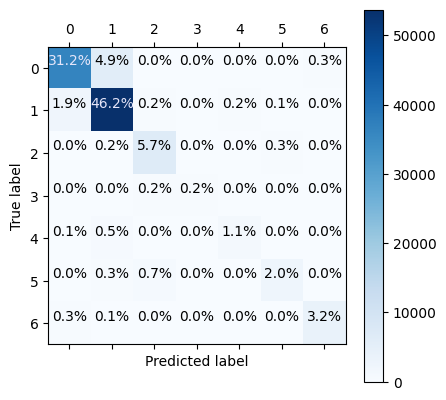

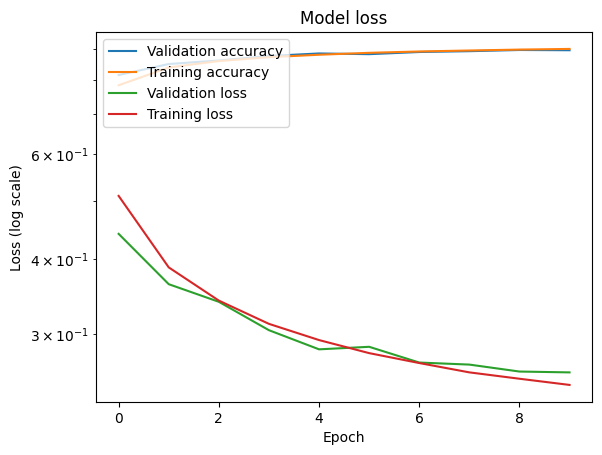

In [ ]:
# Plot training history
visualize_results(history)

# Plot ROC curve (one vs rest untuk multi-kelas)
visualize_roc_curve(y_true, y_pred_proba)

# Plot confusion matrix
visualize_confusion_matrix(y_true, y_pred)

### 6. Menyimpan Model

In [ ]:
# Menyimpan model
mlp_model.save('model_tensorflow_cifar-10_mlp.keras')
print("Model disimpan sebagai 'model_tensorflow_cifar-10_mlp.keras'")

## B. CNN CIFAR-10 Dengan Tensorflow

### 1. Penyusunan Model Neural Network


In [ ]:
# Membuat model CNN
def create_cnn_model():
    model = Sequential([
        # Blok Konvolusional 1
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Blok Konvolusional 2
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Blok Konvolusional 3
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Fully connected layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')  # 10 kelas untuk CIFAR-10
    ])

    return model

# Inisialisasi model
cnn_model = create_cnn_model()

### 2. Kompilasi Model

In [ ]:
# Kompilasi model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### 3. Pelatihan Model

In [ ]:
# Callbacks untuk training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

# Melatih model
history = cnn_model.fit(
    ds_train,
    epochs=100,
    validation_data=ds_test,
    callbacks=callbacks
)

### 4. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [ ]:
# Evaluasi model
test_loss, test_accuracy = cnn_model.evaluate(ds_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Konversi dataset untuk evaluasi metrik lengkap
y_true = []
y_pred = []
y_pred_proba = []

# Menghitung prediksi untuk semua data uji
for images, labels in ds_test:
    predictions = cnn_model.predict(images)
    y_pred_proba.extend(predictions)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

# Mengonversi ke numpy array
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

# Menghitung metrik evaluasi
precision, recall, f1, roc_auc = evaluate_metrics(y_true, y_pred, y_pred_proba)

# Output metrik evaluasi
print("\nMetrik Evaluasi CNN Model dengan TensorFlow:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


### 5. Memvisualisasikan Prediksi dari model yang telah dilatih

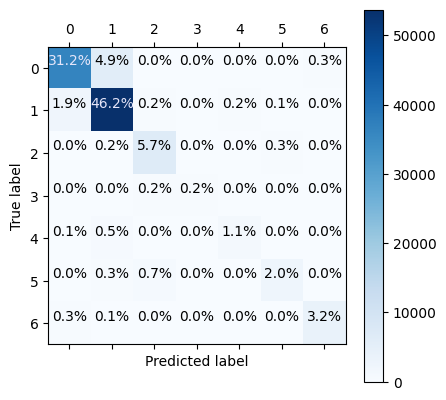

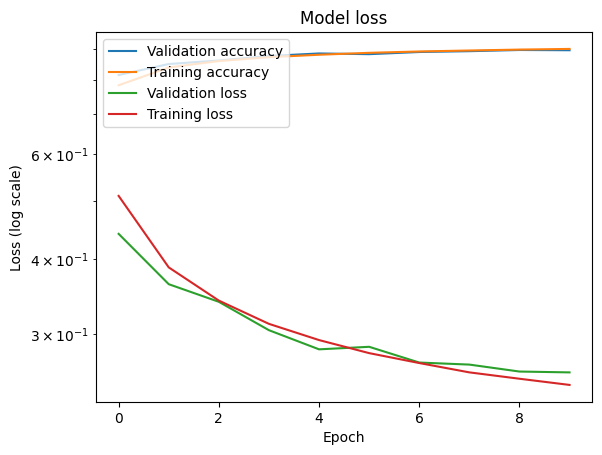

In [ ]:
# Plot training history
visualize_results(history)

# Plot ROC curve (one vs rest untuk multi-kelas)
visualize_roc_curve(y_true, y_pred_proba)

# Plot confusion matrix
visualize_confusion_matrix(y_true, y_pred)

### 6. Menyimpan Model

In [ ]:
# Menyimpan model
cnn_model.save('model_tensorflow_cifar-10_cnn.keras')
print("Model disimpan sebagai 'model_tensorflow_cifar-10_cnn.keras'")

penjelasan lebih rinci tentang persamaan matematika dalam model MLP (Multi-Layer Perceptron) dan CNN (Convolutional Neural Network) sebutkan:

## 1. Konvolusi (Convolution)
Operasi konvolusi dalam CNN bekerja dengan menggeser kernel/filter pada citra input dan melakukan operasi dot product antara kernel dan bagian citra yang tumpang tindih.


$$(I * K)(i, j) = \sum_{m} \sum_{n} I(i-m, j-n) \cdot K(m, n)$$

dimana:
- $I$ adalah citra input
- $K$ adalah kernel atau filter
- $*$ adalah operator konvolusi
- $i, j$ adalah indeks piksel output
- $m, n$ adalah indeks kernel

Contoh:

Jika kernel berukuran 3×3, maka operasi konvolusi menghitung jumlah perkalian elemen kernel dengan bagian citra yang sesuai.

## 2. Aktivasi ReLU (Rectified Linear Unit)

Fungsi aktivasi ReLU yang digunakan dalam model kita didefinisikan sebagai:

$$f(x) = \max(0, x)$$

ReLU akan mengubah semua nilai negatif menjadi 0, sementara nilai positif tetap tidak berubah. Ini membantu model untuk belajar fungsi non-linear dan mengatasi masalah vanishing gradient.

## 3. Batch Normalization

Batch Normalization digunakan untuk menstabilkan dan mempercepat proses pembelajaran dengan menormalkan aktivasi di setiap lapisan. Rumus matematisnya adalah:

$$\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}​$$

$$y_i = \gamma \cdot \hat{x}_i + \beta$$

dimana:
- $x_i$ adalah input ke batch normalization
- $\mu_B$ adalah rata-rata mini-batch
- $\sigma_B^2$ adalah varians mini-batch
- $\epsilon$ adalah konstanta kecil untuk stabilitas numerik
- $\gamma$ dan $\beta$ adalah parameter yang dipelajari
- $y_i$ adalah output batch normalization

## 4. Max Pooling

Max Pooling digunakan untuk mengurangi dimensi spasial dengan memilih nilai maksimum dari setiap region. Secara matematis:

$$\text{MaxPool}(X)_{i,j} = \max_{m,n \in R_{i,j}} X_{m,n}​$$

dimana $R_{i,j}$ adalah region lokal yang berpusat di lokasi $(i,j)$.

## 5. Dropout

Dropout adalah teknik regularisasi yang mencegah overfitting dengan secara acak mematikan neuron selama training. Secara matematis, untuk setiap neuron:

$$\begin{cases}
x/p & \text{dengan probabilitas } p \\
0 & \text{dengan probabilitas } 1-p
\end{cases}$$

dimana $p$ adalah probabilitas mempertahankan (keep probability) dan $1-p$ adalah dropout rate.

## 6. Forward Pass dalam MLP
Dalam MLP, forward pass untuk lapisan fully-connected didefinisikan sebagai:

$$z^{[l]} = W^{[l]} \cdot a^{[l-1]} + b^{[l]}$$
$$a^{[l]} = g(z^{[l]})$$

dimana:
- $W^{[l]}$ adalah matriks bobot untuk lapisan ke-l
- $a^{[l-1]}$ adalah aktivasi dari lapisan sebelumnya
- $b^{[l]}$ adalah vektor bias
- $g$ adalah fungsi aktivasi (seperti ReLU)
- $z^{[l]}$ adalah input terbobot
- $a^{[l]}$ adalah output lapisan

## 7. Fungsi Loss Cross-Entropy
Cross-entropy loss yang digunakan untuk klasifikasi multi-kelas didefinisikan sebagai:

$$L = -\frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} y_{i,c} \log(p_{i,c})$$

dimana:
- $N$ adalah jumlah sampel
- $C$ adalah jumlah kelas
- $y_{i,c}$ adalah indikator (0 atau 1) apakah kelas c adalah label yang benar untuk sampel i
- $p_{i,c}$ adalah probabilitas yang diprediksi bahwa sampel i adalah kelas c

## 8. Optimizer Adam
Adam (Adaptive Moment Estimation) adalah algoritma optimasi yang menggabungkan RMSprop dan momentum. Adam memperbarui bobot menggunakan rumus:

$$m_t = \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot g_t$$
$$v_t = \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot g_t^2$$
$$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}$$
$$\hat{v}_t = \frac{v_t}{1 - \beta_2^t}$$
$$\theta_t = \theta_{t-1} - \alpha \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$$

dimana:
- $g_t$ adalah gradien pada waktu t
- $m_t$ dan $v_t$ adalah estimasi momen pertama dan kedua
- $\hat{m}_t$ dan $\hat{v}_t$ adalah estimasi momen yang dikoreksi
- $\alpha$ adalah learning rate
- $\beta_1$ dan $\beta_2$ adalah exponential decay rates
- $\epsilon$ adalah konstanta kecil untuk stabilitas numerik
- $\theta_t$ adalah parameter yang diperbarui

## 9. Softmax
Fungsi softmax digunakan pada output layer untuk mengubah logits menjadi probabilitas yang berjumlah 1:

$$\text{softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^{k} e^{x_j}}$$

dimana $x_i$ adalah nilai logit untuk kelas i dan k adalah jumlah kelas.

Kesimpulan :

Persamaan-persamaan ini adalah fondasi matematis dari operasi dalam MLP dan CNN. Pemahaman mendalam tentangnya membantu dalam mengembangkan arsitektur yang lebih efisien dan melakukan debugging model.

# Penjelasan Metrik Evaluasi:
## Akurasi

$$ \text{Accuracy} = \frac{\text{True Positives} + \text{True Negatives}}{\text{Total Samples}} $$

Menunjukkan seberapa sering model memprediksi dengan benar.


## Presisi

$$ \text{Precision} = \frac{\text{True Positives}}{\text{True Negatives} + \text{False Positives}} $$

Seberapa andal prediksi positif model.


## Recall (Sensitivity)

$$ \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}} $$

Seberapa baik model menangkap kelas positif.


## F1-Score

$$ \text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $$

Rata-rata harmonik antara presisi dan recall.


## ROC (Receiver Operating Characteristic) Curve

ROC Curve memplot hubungan antara True Positive Rate (TPR) dan False Positive Rate (FPR):

$$ \text{True Positive Rate (TPR)} = \text{Recall} $$

$$ \text{False Positive Rate (FPR)} = \frac{\text{False Positives}}{ \text{False Positives} + \text{True Negatives}} $$


## AUC-ROC

$$ AUC = \int_{0}^{1} TPR(x) \, dx $$

AUC (Area Under Curve) adalah area di bawah kurva ROC (Receiver Operating Characteristic)